In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from datetime import datetime
from tensorflow import keras
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn import datasets
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib as mpl  
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import os
# plt.style.use('science')
# os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
# plt.style.use(['science','ieee'])

In [2]:
# Convert dataframe to a tf.data.Dataset
global train, test, train_ds, test_ds
def df_to_dataset(dataframe, shuffle=True, batch_size=20):
  import tensorflow as tf
  dataframe1 = dataframe.copy()
  labels = dataframe1.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe1), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe1))
  ds = ds.batch(batch_size)
  return ds

In [3]:
# SVM model
def modify_label(label):
    if label == 0:
        return -1
    return label

def svm_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    df['label'] = df['label'].map(modify_label)
    labels = df['label'].values
    features = df.drop(['label','file_id', 'Unnamed: 0'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    acc = accuracy_score(targs, preds)
    prec = precision_score(targs, preds)
    rec = recall_score(targs, preds)
    f1 = f1_score(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds, acc, prec, rec, f1

In [4]:
# Logistic Regression model
def lr_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.4)
    
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    acc = accuracy_score(targs, preds)
    prec = precision_score(targs, preds)
    rec = recall_score(targs, preds)
    f1 = f1_score(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds, acc, prec, rec, f1

In [5]:
# K-Nearest Neighbors model
def knn_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    
    knn = KNeighborsClassifier(n_neighbors=50)
    
    clf = knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    acc = accuracy_score(targs, preds)
    prec = precision_score(targs, preds)
    rec = recall_score(targs, preds)
    f1 = f1_score(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds, acc, prec, rec, f1

In [6]:
# Random Forest model
def rf_train():
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    
    rf = RandomForestClassifier(random_state=0, n_estimators=1)
    
    clf = rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    acc = accuracy_score(targs, preds)
    prec = precision_score(targs, preds)
    rec = recall_score(targs, preds)
    f1 = f1_score(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds, acc, prec, rec, f1

In [15]:
# Training Model
def train_model(data):
    import tensorflow as tf
    global train, test, train_ds, test_ds
    if data is None:
        return None
    if len(data.columns) == 0:
        return None
    feature_columns = []
    for feature in data.columns:
        if feature == 'label':
            continue
        feature_columns.append(tf.feature_column.numeric_column(feature))
    
    batch_size=20
    train, test = train_test_split(data, test_size=0.2)
    train_ds = df_to_dataset(train, batch_size=batch_size)
    test_ds = df_to_dataset(test, batch_size=batch_size)
    
    model = tf.keras.Sequential([
          tf.keras.layers.DenseFeatures(feature_columns),
          #tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'Recall', 'Precision'])
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    model.fit(train_ds,
          validation_data = test_ds,
          epochs = 100,
          callbacks = [tensorboard_callback])
    return model

In [16]:
# Deep Learning Model training on choosen features
def deep_model_train():
    feature_df = pd.read_csv('TCGA_Labeled_Selected_Final_Features.csv', index_col=0)
    df_t2 = shuffle(feature_df)
    return train_model(df_t2)

model = deep_model_train()

Epoch 1/100


18/24 [=====================>........] - ETA: 0s - loss: 23582.9922 - auc: 0.4985 - accuracy: 0.8944 - recall: 0.9969 - precision: 0.8969WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'GYPE': <tf.Tensor 'IteratorGetNext:40' shape=(None,) dtype=int64>, 'ADRB2': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=int64>, 'CD5L': <tf.Tensor 'IteratorGetNext:22' shape=(None,) dtype=int64>, 'ANGPT4': <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=int64>, 'GPM6A': <tf.Tensor 'IteratorGetNext:37' shape=(None,) dtype=int64>, 'NCKAP5': <tf.Tensor 'IteratorGetNext:53' shape=(None,) dtype=int64>, 'CD300LG': <tf.Tensor 'IteratorGetNext:21' shape=(None,) dtype=int64>, 'SGCG': <tf.Tensor 'IteratorGetNext:66' shape=(None,) dtype=int64>, 'SH3GL3': <tf.Tensor 'IteratorGetNext:67' shape=(None,) dtype=int64>, 'CA4': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=int64>, 'CAVIN2': <tf.Tensor 'IteratorGetNext:18' shape=(None,) dtype=int64>,

24/24 [==============================] - 16s 412ms/step - loss: 22752.0801 - auc: 0.4988 - accuracy: 0.8989 - recall: 0.9977 - precision: 0.9008 - val_loss: 26209.9316 - val_auc: 0.5000 - val_accuracy: 0.8992 - val_recall: 1.0000 - val_precision: 0.8992
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 20115.9375 - auc: 0.4977 - accuracy: 0.8968 - recall: 0.9953 - precision: 0.9006 - val_loss: 22832.2383 - val_auc: 0.4907 - val_accuracy: 0.8824 - val_recall: 0.9813 - val_precision: 0.8974
Epoch 3/100
24/24 [==============================] - 1s 24ms/step - loss: 17438.1016 - auc: 0.4907 - accuracy: 0.8842 - recall: 0.9813 - precision: 0.8994 - val_loss: 19351.1426 - val_auc: 0.4907 - val_accuracy: 0.8824 - val_recall: 0.9813 - val_precision: 0.8974
Epoch 4/100
24/24 [==============================] - 1s 23ms/step - loss: 14702.7891 - auc: 0.4778 - accuracy: 0.8611 - recall: 0.9556 - precision: 0.8969 - val_loss: 15961.9639 - val_auc: 0.4626 - val_accuracy: 0.8319

In [18]:
# Saving the deep learning model for future use
model.save('Model/model_BTP2')
# saved_model = init_model()
# saved_model = tf.keras.models.load_model('Model/model.h5')


INFO:tensorflow:Assets written to: Model/model_BTP2\assets


INFO:tensorflow:Assets written to: Model/model_BTP2\assets


In [17]:
# Testing the Deep Learning Model now
import tensorflow as tf
x = tf.data.Dataset.from_tensor_slices(test.drop(['label'], axis = 1).to_dict('list'))
x1 = x.batch(10)
pp = model.predict(x1)
DNN_fpr, DNN_tpr, DNN_thresholds = roc_curve(test['label'].values, pp)
DNN_accuracy = accuracy_score(test['label'].values, pp.round())
DNN_precision = precision_score(test['label'].values, pp.round())
DNN_recall = recall_score(test['label'].values, pp.round())
DNN_f1 = f1_score(test['label'].values, pp.round())
auc(DNN_fpr, DNN_tpr)

12/12 [==============================] - 3s 10ms/step


0.9906542056074766

In [38]:
svm_fpr,svm_tpr,thre, svm_acc, svm_pre, svm_rec, svm_f1 = svm_train()
auc(svm_fpr, svm_tpr)

0.9166666666666667

In [39]:
lr_fpr,lr_tpr,thre, lr_acc, lr_pre, lr_rec, lr_f1 = lr_train()
auc(lr_fpr,lr_tpr)

0.9766245909303413

In [40]:
knn_fpr,knn_tpr,thre, knn_acc, knn_pre, knn_rec, knn_f1 = knn_train()
auc(knn_fpr,knn_tpr)

0.9551948051948053

In [41]:
rf_fpr,rf_tpr,thre, rf_acc, rf_pre, rf_rec, rf_f1 = rf_train()
auc(rf_fpr,rf_tpr)

0.9133986928104575

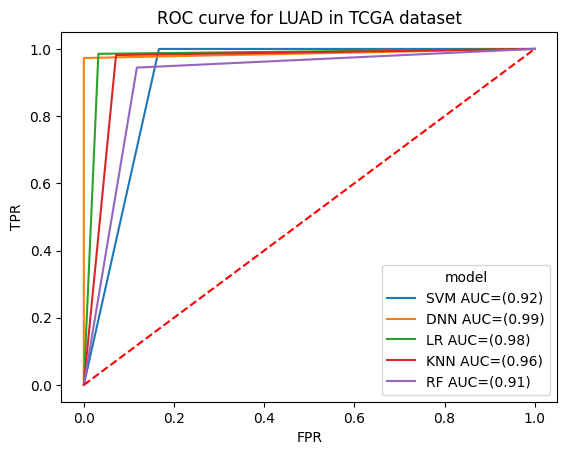

In [44]:
# Comparing the ROC curves of all the models
# with plt.style.context(['science']):
fig, ax = plt.subplots()        
for p in ['SVM', 'DNN','LR','KNN','RF']: 
    fpr, tpr = get_ff(p)
    roc_auc=auc(fpr, tpr)
    ax.plot(fpr, tpr, label='%s AUC=(%.2f)' %(p, roc_auc)) 
ax.plot([0,1],[0,1],'r--')
ax.legend(loc='lower right') 
ax.legend(title='model')       
ax.set(xlabel='FPR')        
ax.set(ylabel='TPR')
plt.title('ROC curve for LUAD in TCGA dataset')      
fig.savefig('fig1.jpg', dpi=300)

In [43]:
def get_ff(model_name):
    if model_name == 'SVM':
        return svm_fpr, svm_tpr
    if model_name == 'DNN':
        return DNN_fpr, DNN_tpr
    if model_name == 'LR':
        return lr_fpr, lr_tpr
    if model_name == 'KNN':
        return knn_fpr, knn_tpr
    if model_name == 'RF':
        return rf_fpr, rf_tpr

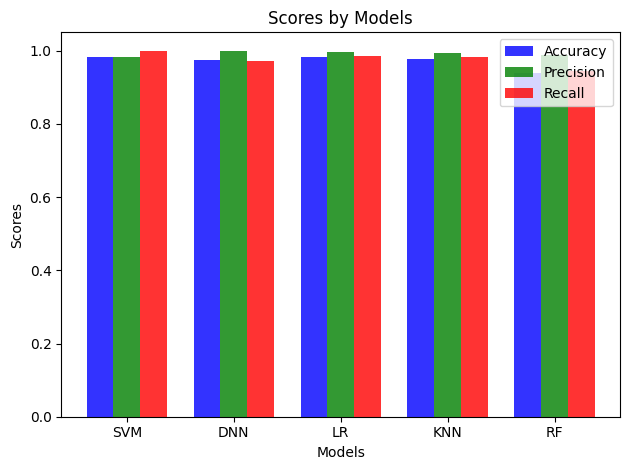

In [46]:
# Compare the accuracy, precision and recall of all the models as well
def get_metrics(model_name):
    if model_name == 'SVM':
        return svm_acc, svm_pre, svm_rec
    if model_name == 'DNN':
        return DNN_acc, DNN_pre, DNN_rec
    if model_name == 'LR':
        return lr_acc, lr_pre, lr_rec
    if model_name == 'KNN':
        return knn_acc, knn_pre, knn_rec
    if model_name == 'RF':
        return rf_acc, rf_pre, rf_rec

# Plotting the bar graph for accuracy, precision and recall

# data to plot
n_groups = 5
acc = (svm_acc, DNN_accuracy, lr_acc, knn_acc, rf_acc)
pre = (svm_pre, DNN_precision, lr_pre, knn_pre, rf_pre)
rec = (svm_rec, DNN_recall, lr_rec, knn_rec, rf_rec)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, acc, bar_width, alpha=opacity, color='b', label='Accuracy')
rects2 = plt.bar(index + bar_width, pre, bar_width, alpha=opacity, color='g', label='Precision')
rects3 = plt.bar(index + bar_width + bar_width, rec, bar_width, alpha=opacity, color='r', label='Recall')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Scores by Models')
plt.xticks(index + bar_width, ('SVM', 'DNN', 'LR', 'KNN', 'RF'))
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('fig2.jpg', dpi=300)


In [28]:
# K-Fold Cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

def cross_validation(model):
    df = pd.read_csv('TCGA_Labeled_Final_Features.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label'], axis=1)
    feature_arr = features.values
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    cv_results = cross_validate(model, feature_arr, labels, cv=5, scoring=metrics, return_train_score=True)
    return cv_results

model = KerasClassifier(build_fn=deep_model_train(), optimizer="adam", epochs=100, verbose=0)
Kfold_results = cross_validation(model)

# Grouped Bar Chart for both training and validation data
def plot_bar_chart(train_scores, val_scores):
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = train_scores
    bars2 = val_scores

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Training')
    plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Validation')

    plt.title('Metrics scores in 5 folds', fontweight='bold')

    # Add xticks on the middle of the group bars
    plt.xlabel('Metrics', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['Accuracy', 'Precision', 'Recall', 'F1'])

    # Create legend & Show graphic
    plt.legend()
    plt.show()

plot_bar_chart(Kfold_results['train_accuracy'], Kfold_results['test_accuracy'])
plot_bar_chart(Kfold_results['train_precision'], Kfold_results['test_precision'])
plot_bar_chart(Kfold_results['train_recall'], Kfold_results['test_recall'])
plot_bar_chart(Kfold_results['train_f1'], Kfold_results['test_f1'])


Epoch 1/100
24/24 [==============================] - 10s 120ms/step - loss: 4412.7319 - auc: 0.4058 - accuracy: 0.7137 - recall: 0.7934 - precision: 0.8756 - val_loss: 2567.6709 - val_auc: 0.2339 - val_accuracy: 0.4286 - val_recall: 0.4679 - val_precision: 0.8361
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 1788.5129 - auc: 0.3067 - accuracy: 0.3768 - recall: 0.3944 - precision: 0.8155 - val_loss: 1154.1003 - val_auc: 0.3743 - val_accuracy: 0.3529 - val_recall: 0.3486 - val_precision: 0.8636
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 718.4080 - auc: 0.5782 - accuracy: 0.5495 - recall: 0.5423 - precision: 0.9240 - val_loss: 377.6173 - val_auc: 0.7261 - val_accuracy: 0.7479 - val_recall: 0.7523 - val_precision: 0.9647
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 255.4796 - auc: 0.8071 - accuracy: 0.8126 - recall: 0.8146 - precision: 0.9720 - val_loss: 203.5171 - val_auc: 0.8495 - val_accuracy: 0.8908

INFO:tensorflow:Assets written to: C:\Users\AKASHY~1\AppData\Local\Temp\tmp__znszfo\assets


INFO:tensorflow:Assets written to: C:\Users\AKASHY~1\AppData\Local\Temp\tmp__znszfo\assets


ValueError: Weights for model sequential_11 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [12]:
# Apply grasshopper optimization algorithm to find the best features
import numpy as np
import pandas as pd
import random
import math
import time

# Load the dataset
df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
labels = df['label'].values
features = df.drop(['label','file_id'], axis=1)
feature_arr = features.values
X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)

# Grasshopper Optimization Algorithm
def GOA(num_iter, lb, ub, dim, searchAgents_no, X_train, X_test, y_train, y_test):
    # initialize position vector and score for the leader grasshopper
    Leader_pos=np.zeros(dim)
    Leader_score=float("inf") #change this to -inf for maximization problems

    #Initialize the positions of grasshoppers
    print(searchAgents_no, dim)
    Positions = np.zeros((searchAgents_no, dim))
    # print(Positions)
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0, 1, searchAgents_no) * (ub[i] - lb[i]) + lb[i]

    Convergence_curve=np.zeros(num_iter)

    t=0  # Loop counter

    # Main loop
    while t < num_iter:
        for i in range(0, searchAgents_no):
            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i, j] = np.clip(Positions[i, j], lb[j], ub[j])

            # Calculate objective function for each search agent
            #fitness = F1(Positions[i, :])
            fitness = F2(Positions[i, :], X_train, X_test, y_train, y_test)

            # Update the leader
            if fitness < Leader_score: # Change this to > for maximization problem
                Leader_score = fitness # Update alpha
                Leader_pos = Positions[i, :].copy() # copy current grasshopper position into the leader position

        a = 2 - t * ((2) / num_iter) # a decreases linearly fron 2 to 0

        # Update the Position of search agents including omegas
        for i in range(0, searchAgents_no):
            for j in range(0, dim):

                # Update r1, r2, and r3 for Eq. (3.3) in the paper
                r1 = random.random() # r1 is a random number in [0,1]
                r2 = random.random() # r2 is a random number in [0,1]
                r3 = random.random() # r3 is a random number in [0,1]

                # Eq. (3.3) in the paper
                if r3 < 0.5:
                    Positions[i, j] = Positions[i, j] + a * (
                                math.exp(b * r1) * math.sin(c * r2) * abs(r1 * Leader_pos[j] - Positions[i, j]))
                else:
                    Positions[i, j] = Positions[i, j] + a * (
                                math.exp(b * r1) * math.cos(c * r2) * abs(r1 * Leader_pos[j] - Positions[i, j]))

        Convergence_curve[t] = Leader_score
        if (t % 1 == 0):
            print(['At iteration ' + str(t) + ' the best fitness is ' + str(Leader_score)])
        t = t + 1

    return Leader_pos, Leader_score, Convergence_curve

# Objective function 1
def F1(sol):
    # Sphere function sum_j=1^d (x_j^2)
    return sum(sol ** 2)

# Objective function 2
def F2(sol, X_train, X_test, y_train, y_test):
    # Logistic Regression
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict(X_test)
    return 1 - accuracy_score(y_test, preds)

# Main program
# Select objective function
#F = F1
#F = F2

# Select optimizers
function_name = ['GOA', 'WOA', 'MVO', 'MFO', 'CS', 'GWO', 'MothFlame', 'Bat', 'SineCosine', 'Flower', 'ShuffledFrog', 'Spiral', 'Firefly', 'Swarm', 'AntLion', 'Dragonfly', 'KrillHerd', 'Cuckoo', 'Whale', 'Sailfish', 'Grasshopper', 'SpiderMonkey', 'Butterfly', 'Mosquito', 'Mantis', 'Wasp', 'Zombie', 'Vampire', 'Ghoul', 'Werewolf', 'Levy', 'Quadratic', 'Step', 'Rastrigin', 'Rosenbrock', 'Griewank']
optimizer = GOA

# Select number of repetitions for each experiment.
# To obtain meaningful statistical results, usually 30 independent runs are executed for each algorithm.
NumOfRuns = 1

# Select general parameters for all optimizers (population size, number of iterations)
PopulationSize = X_train.shape[1] 
Iterations = 50

# Select parameter values for each optimizer
# For GOA
lb = -100
ub = 100
dim = len(X_train[0])
# dim = 30

# Run the algorithm
for i in range(0, NumOfRuns):
    print('Run: ' + str(i + 1))
    start_time = time.time()
    [best, bestValue, Convergence_curve] = optimizer(Iterations, lb, ub, dim, PopulationSize, X_train, X_test, y_train, y_test)
    end_time = time.time()
    execution_time = end_time - start_time
    print('The best solution obtained by ' + optimizer.__name__ + ' is: ' + str(best))
    print('The best optimal value of the objective funciton found by ' + optimizer.__name__ + ' is: ' + str(bestValue))
    print('The time taken is ' + str(execution_time) + ' seconds')
    plt.plot(Convergence_curve)
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.title(optimizer.__name__ + ' - ' + function_name[1])
    plt.grid(True)
    plt.show()
    # Save convergence information
    #pd.DataFrame(Convergence_curve).to_csv(optimizer.__name__ + " - " + function_name[1] + ".csv")

# Apply the best features to the model
# Apply the best features to the model
def apply_best_features(best):
    df = pd.read_csv('TCGA_Labeled.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label','file_id'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = train_test_split(feature_arr, labels, test_size=0.3)
    X_train = X_train[:, best]
    X_test = X_test[:, best]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = apply_best_features(best)



Run: 1
30 19944
(30, 19944)


TypeError: 'int' object is not subscriptable